# Multilayer Perceptron without 'Cognitive_Test_Scores'

## Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(42)

In [2]:
data = pd.read_csv('data/dementia_patients_cleaned_2_After EDAC.csv')
data.head(5)

,Diabetic,HeartRate,BloodOxygenLevel,BodyTemperature,Weight,MRI_Delay,Age,Education_Level,Dominant_Hand,Gender,Family_History,Smoking_Status,APOE_ε4,Physical_Activity,Depression_Status,Nutrition_Diet,Sleep_Quality,Chronic_Health_Conditions,Dementia
0,True,98,96.230743,36.224852,57.563978,36.421028,60,2,Left,Female,False,2,False,1,True,Low-Carb Diet,False,True,0
1,False,78,93.032122,36.183874,56.832335,31.157633,61,3,Right,Male,False,1,True,3,True,Low-Carb Diet,False,True,1
2,False,89,93.566504,37.326321,59.759066,37.640435,69,2,Right,Male,True,1,False,3,True,Mediterranean Diet,False,True,0
3,False,60,93.906510,37.030620,58.266471,50.673992,78,3,Left,Female,True,0,False,2,True,Balanced Diet,False,True,1
4,True,67,97.508994,36.062121,67.705027,27.810601,77,3,Right,Male,True,0,True,2,True,Low-Carb Diet,True,True,1


In [3]:
X = data.drop('Dementia', axis=1)
y = data['Dementia'].astype(np.float32)
print('Len of X', len(X))
print('Len of y', len(y))

Len of X 1000
Len of y 1000


In [4]:
# Assume that 'Dominant_Hand', 'Gender', and 'Nutrition_Diet' are the categorical columns
categorical_cols = ['Dominant_Hand', 'Gender', 'Nutrition_Diet']
data = pd.get_dummies(data, columns=categorical_cols)

# Convert boolean columns to integer
bool_cols = ['Diabetic', 'Family_History', 'APOE_ε4', 'Depression_Status', 'Sleep_Quality', 'Chronic_Health_Conditions']
for col in bool_cols:
    data[col] = data[col].astype(int)

# Define columns that need to be scaled
numerical_cols = ['HeartRate', 'BloodOxygenLevel', 'BodyTemperature', 'Weight', 'MRI_Delay', 'Age', 
                  'Physical_Activity', 'Smoking_Status', 'Education_Level']
scaler = StandardScaler()
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])

# Split the dataset into features and target variable
X = data.drop('Dementia', axis=1).values  # Convert DataFrame to numpy array
y = data['Dementia'].astype(np.float32).values  # Convert Series to numpy array

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


## Pytorch Dataset:
This Python dataset can be used with the Python library.  
- Normalize the data  
- Convert it to a Pytorch tensor

In [5]:
class DementiaDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)

In [6]:
# Create dataset instances
train_data = DementiaDataset(X_train_scaled, y_train)
test_data = DementiaDataset(X_test_scaled, y_test)

# Create DataLoader instances
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32)

In [7]:
next(iter(train_loader))

[tensor([[-1.0487, -1.1649, -1.5822, -0.4561, -0.9643,  0.6982, -0.4108, -0.5062,
           0.9656,  0.5739,  0.6683, -1.2264,  0.0000, -0.9276,  0.0000,  0.9802,
          -0.9802, -1.0356,  1.0356, -0.7157,  1.4089, -0.6959],
         [ 0.9536, -0.4208, -1.6928,  1.0746, -0.0360,  0.6580, -0.8548, -0.5062,
           0.9656, -0.9720,  0.6683,  1.2449,  0.0000,  1.0780,  0.0000,  0.9802,
          -0.9802, -1.0356,  1.0356, -0.7157,  1.4089, -0.6959],
         [-1.0487,  0.3233,  0.1900,  0.1342,  0.8760, -1.2375,  1.4760,  0.5680,
          -1.0356, -0.9720,  0.6683,  1.2449,  0.0000,  1.0780,  0.0000, -1.0202,
           1.0202,  0.9656, -0.9656, -0.7157, -0.7098,  1.4371],
         [-1.0487, -1.5782, -1.4637,  1.2013,  1.5851,  0.3583, -1.2987,  0.5680,
          -1.0356,  0.5739,  0.6683,  0.0093,  0.0000,  1.0780,  0.0000,  0.9802,
          -0.9802, -1.0356,  1.0356,  1.3972, -0.7098, -0.6959],
         [-1.0487, -1.5782,  1.4310,  1.4715, -0.3715,  0.9432,  0.5881, -0.5062,
  

## Model Optimization  
We use this model to utilizes the Adam optimizer for efficient stochastic optimization, well-suited for large datasets and high-dimensional parameter spaces. The loss function employed is the Binary Cross Entropy Loss (BCELoss), which is ideal for binary classification problems, calculating the difference between two probability distributions.


In [8]:
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP, self).__init__()
        self.linear1 = nn.Linear(input_dims, hidden_dims)
        self.linear2 = nn.Linear(hidden_dims, hidden_dims// 2)
        self.linear3 = nn.Linear(hidden_dims// 2, hidden_dims//4)
        self.output = nn.Linear(hidden_dims//4, output_dims)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.linear3(x)
        x = self.relu(x)
        out = self.output(x)
        out = self.sigmoid(out)
        return out.squeeze(1)

In [9]:
input_dims = X_train.shape[1]  # Adjust this to match the actual number of features

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = MLP(input_dims=input_dims, hidden_dims=64, output_dims=1).to(device)

In [10]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

# Model Training

In [11]:
# Define lists to store metrics
train_losses = []
test_losses = []
train_accs = []
test_accs = []
train_precisions = []
test_precisions = []
train_recalls = []
test_recalls = []
train_f1_scores = []
test_f1_scores = []

num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_targets = []
    train_predictions = []

    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model(X)
        predicted = outputs.round()
        train_predictions.extend(predicted.detach().cpu().numpy())
        train_targets.extend(y.detach().cpu().numpy())
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    train_acc = accuracy_score(train_targets, train_predictions)
    train_accs.append(train_acc)
    train_precision = precision_score(train_targets, train_predictions)
    train_precisions.append(train_precision)
    train_recall = recall_score(train_targets, train_predictions)
    train_recalls.append(train_recall)
    train_f1 = f1_score(train_targets, train_predictions)
    train_f1_scores.append(train_f1)

    model.eval()
    test_loss = 0.0
    test_targets = []
    test_predictions = []

    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            predicted = outputs.round()
            test_predictions.extend(predicted.detach().cpu().numpy())
            test_targets.extend(y.detach().cpu().numpy())
            loss = criterion(outputs, y)
            test_loss += loss.item()

    test_loss /= len(test_loader)
    test_losses.append(test_loss)
    test_acc = accuracy_score(test_targets, test_predictions)
    test_accs.append(test_acc)
    test_precision = precision_score(test_targets, test_predictions)
    test_precisions.append(test_precision)
    test_recall = recall_score(test_targets, test_predictions)
    test_recalls.append(test_recall)
    test_f1 = f1_score(test_targets, test_predictions)
    test_f1_scores.append(test_f1)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, Train Precision: {train_precision:.4f}, Train Recall: {train_recall:.4f}, Train F1 Score: {train_f1:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}, Test Precision: {test_precision:.4f}, Test Recall: {test_recall:.4f}, Test F1 Score: {test_f1:.4f}")

Epoch 1/100, Train Loss: 0.6771, Train Accuracy: 0.5525, Train Precision: 0.7143, Train Recall: 0.0923, Train F1 Score: 0.1636, Test Loss: 0.6628, Test Accuracy: 0.6050, Test Precision: 0.7213, Test Recall: 0.4151, Test F1 Score: 0.5269
Epoch 2/100, Train Loss: 0.5719, Train Accuracy: 0.7125, Train Precision: 0.6858, Train Recall: 0.7256, Train F1 Score: 0.7051, Test Loss: 0.6180, Test Accuracy: 0.6750, Test Precision: 0.6694, Test Recall: 0.7642, Test F1 Score: 0.7137
Epoch 3/100, Train Loss: 0.5285, Train Accuracy: 0.7400, Train Precision: 0.7021, Train Recall: 0.7836, Train F1 Score: 0.7406, Test Loss: 0.6083, Test Accuracy: 0.7000, Test Precision: 0.6917, Test Recall: 0.7830, Test F1 Score: 0.7345
Epoch 4/100, Train Loss: 0.4995, Train Accuracy: 0.7625, Train Precision: 0.7311, Train Recall: 0.7889, Train F1 Score: 0.7589, Test Loss: 0.6126, Test Accuracy: 0.7000, Test Precision: 0.6949, Test Recall: 0.7736, Test F1 Score: 0.7321
Epoch 5/100, Train Loss: 0.4805, Train Accuracy: 0.7

Epoch 42/100, Train Loss: 0.0015, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000, Test Loss: 2.4274, Test Accuracy: 0.6150, Test Precision: 0.6629, Test Recall: 0.5566, Test F1 Score: 0.6051
Epoch 43/100, Train Loss: 0.0014, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000, Test Loss: 2.4137, Test Accuracy: 0.6150, Test Precision: 0.6629, Test Recall: 0.5566, Test F1 Score: 0.6051
Epoch 44/100, Train Loss: 0.0013, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000, Test Loss: 2.4613, Test Accuracy: 0.6150, Test Precision: 0.6629, Test Recall: 0.5566, Test F1 Score: 0.6051
Epoch 45/100, Train Loss: 0.0012, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000, Test Loss: 2.4585, Test Accuracy: 0.6150, Test Precision: 0.6629, Test Recall: 0.5566, Test F1 Score: 0.6051
Epoch 46/100, Train Loss: 0.0011, Train Accuracy

Epoch 78/100, Train Loss: 0.0003, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000, Test Loss: 2.9414, Test Accuracy: 0.6150, Test Precision: 0.6629, Test Recall: 0.5566, Test F1 Score: 0.6051
Epoch 79/100, Train Loss: 0.0003, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000, Test Loss: 2.9741, Test Accuracy: 0.6050, Test Precision: 0.6552, Test Recall: 0.5377, Test F1 Score: 0.5907
Epoch 80/100, Train Loss: 0.0003, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000, Test Loss: 2.9667, Test Accuracy: 0.6100, Test Precision: 0.6591, Test Recall: 0.5472, Test F1 Score: 0.5979
Epoch 81/100, Train Loss: 0.0003, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000, Test Loss: 2.9865, Test Accuracy: 0.6100, Test Precision: 0.6591, Test Recall: 0.5472, Test F1 Score: 0.5979
Epoch 82/100, Train Loss: 0.0002, Train Accuracy

Text(0.5, 1.0, 'Error Graph')

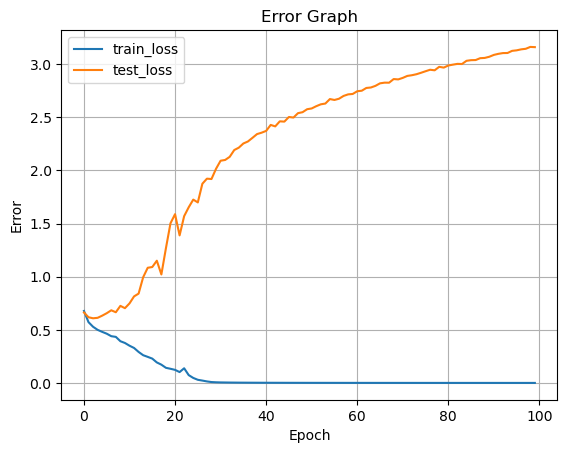

In [12]:
plt.plot(train_losses, label='train_loss')
plt.plot(test_losses, label='test_loss')
# plt.ylim([0, 40])
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.title('Error Graph')

Text(0.5, 1.0, 'Accuracy Graph')

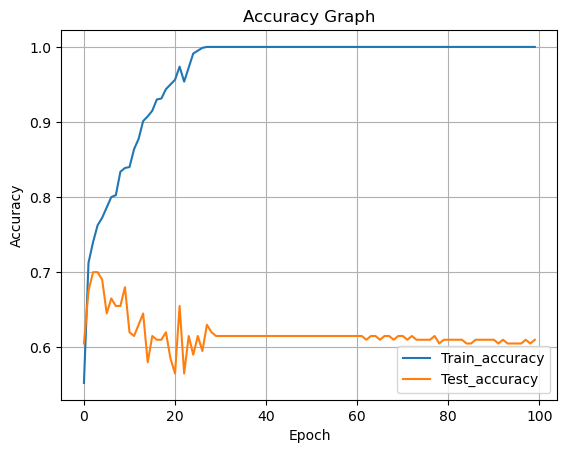

In [13]:
plt.plot(train_accs, label='Train_accuracy')
plt.plot(test_accs, label='Test_accuracy')
# plt.ylim([0, 40])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.title('Accuracy Graph')

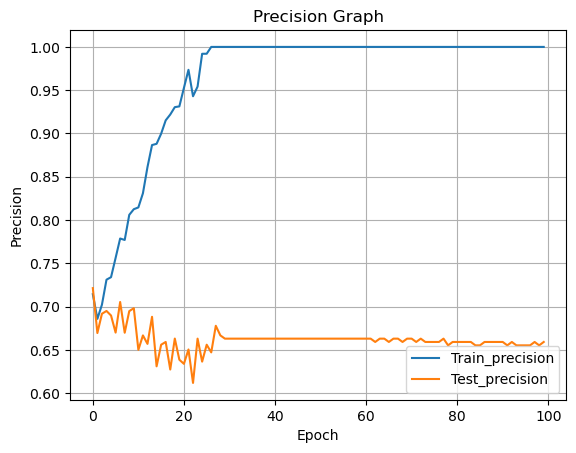

In [14]:
plt.plot(train_precisions, label='Train_precision')
plt.plot(test_precisions, label='Test_precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)
plt.title('Precision Graph')
plt.show()

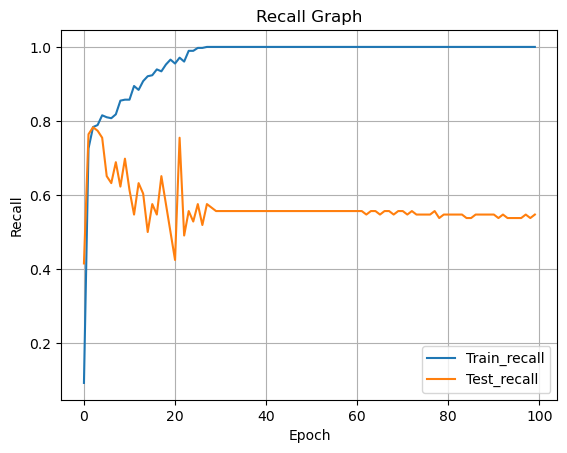

In [15]:
plt.plot(train_recalls, label='Train_recall')
plt.plot(test_recalls, label='Test_recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)
plt.title('Recall Graph')
plt.show()

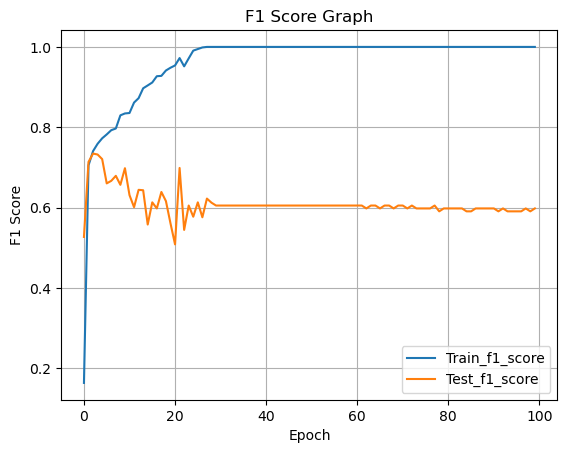

In [16]:
plt.plot(train_f1_scores, label='Train_f1_score')
plt.plot(test_f1_scores, label='Test_f1_score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.title('F1 Score Graph')
plt.show()

To conclude our findings From the test set of our logistic regression model, we obtained the following: Accuracy = 0.740, Precision = 0.715, Recall = 0.809, F1 Score = 0.759.

From the test Epoch 100/100 of our MLP model, we obtained the following: Accuracy: 0.6100, Precision: 0.6591, Recall: 0.5472, F1 Score = 0.5979.

Since logistics regression is higher value we can say that logistics regression works better than MLP. But on the other hand MLP works better when we have incomplete data.